# Import Libraries

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the data

In [2]:
dataset_path = '/kaggle/input/blur-dataset'

IN = '/kaggle/input/blur-dataset/motion_blurred'
OUT = '/kaggle/input/blur-dataset/sharp'

def data_load(path):
    result = []
    for file in tqdm(sorted(os.listdir(path))):
      if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(path + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        result.append(image)
    return np.array(result)

input_images = data_load(IN)
output_images = data_load(OUT)

100%|██████████| 350/350 [00:18<00:00, 18.75it/s]


# Split the data into Train,Test

In [3]:
split_size = int(len(input_images) * 0.8)

x_train = input_images[:split_size]
y_train = output_images[:split_size]

x_test = input_images[split_size:]
y_test = output_images[split_size:]


x_train.shape,y_train.shape,x_test.shape,y_test.shape

((219, 128, 128, 3), (219, 128, 128, 3), (55, 128, 128, 3), (55, 128, 128, 3))

# Show Sample of data

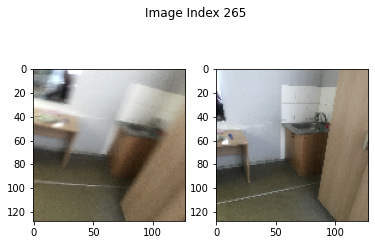

In [4]:
r = random.randint(0, len(input_images)-1)

fig = plt.figure()
plt.suptitle(f'Image Index {r}')
ax = fig.add_subplot(1, 2, 1)
ax.imshow(input_images[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(output_images[r])

# Build The Model

In [5]:
# Network Parameters

INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32
KERNEL_SIZE = 3
LATENT_DIM = 256

layer_filters = [64, 128, 256]

### The Encoder

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=2,activation=tf.nn.relu,padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=2,activation=tf.nn.relu,padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=256,kernel_size=3,strides=2,activation=tf.nn.relu,padding='same')
        self.flat = tf.keras.layers.Flatten()
        self.dns = tf.keras.layers.Dense(256,name='encoder_latent')
        
    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dns(x)
        return x
    
    def build(self,shape=(128,128,3)):
        inputs = tf.keras.layers.Input(shape = shape, name = 'encoder_input')
        return tf.keras.Model(inputs,self.call(inputs),name='encoder')        

In [7]:
encoder = Encoder()
encoder.build().summary()

2022-10-20 08:44:04.965507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 08:44:04.966509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 08:44:05.218670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 08:44:05.219614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 08:44:05.220395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
encoder_latent (Dense)       (None, 256)               16777472  
Total params: 17,148,288
Trainable params: 17,148,288
Non-trainable params: 0
_______________________________________________

In [8]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.dns = tf.keras.layers.Dense((16*16*256),name='decoder_latent')
        self.rshape = tf.keras.layers.Reshape((16,16,256))
        self.convt1 = tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=3,strides=2,activation='relu',padding='same')
        self.convt2 = tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=3,strides=2,activation='relu',padding='same')
        self.convt3 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,activation='relu',padding='same')
        self.out = tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3,activation='sigmoid',padding='same',name='decoder_output')
        
    def call(self,inputs):
        x = self.dns(inputs)
        x = self.rshape(x)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        x = self.out(x)
        return x
    
    def build(self,shape=(256,)):
        inputs = tf.keras.layers.Input(shape = shape, name = 'decoder_input')
        return tf.keras.Model(inputs,self.call(inputs),name='decoder')

In [9]:
decoder = Decoder()
decoder.build().summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
decoder_latent (Dense)       (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 128, 3)       1731

In [10]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self,inputs):
        inpt = inputs
        x = self.encoder(inpt)
        x = self.decoder(x)
        return x
        
    def build(self,shape=(128,128,3)):
        inputs = tf.keras.layers.Input(shape = shape, name = 'AutoEncoder_Input') 
        return tf.keras.Model(inputs, self.call(inputs) , name='AutoEncoder')        

In [11]:
autoencoder = AutoEncoder()
autoencoder.build().summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AutoEncoder_Input (InputLaye [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Encoder)            (None, 256)               17148288  
_________________________________________________________________
decoder (Decoder)            (None, 128, 128, 3)       17803395  
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [13]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]

In [14]:
history = autoencoder.fit(input_images,
                      output_images,
                      validation_data=(input_images, output_images),
                      epochs=150,
                      batch_size=BATCH_SIZE,
                      callbacks=callbacks)

2022-10-20 08:44:11.791649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-10-20 08:44:14.845207: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 18s 300ms/step - loss: 0.0699 - accuracy: 0.6182 - val_loss: 0.0683 - val_accuracy: 0.6679
Epoch 2/150
9/9 [==============================] - 1s 135ms/step - loss: 0.0669 - accuracy: 0.6678 - val_loss: 0.0640 - val_accuracy: 0.6614
Epoch 3/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0646 - accuracy: 0.6473 - val_loss: 0.0638 - val_accuracy: 0.6598
Epoch 4/150
9/9 [==============================] - 1s 132ms/step - loss: 0.0617 - accuracy: 0.6587 - val_loss: 0.0585 - val_accuracy: 0.6671
Epoch 5/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0575 - accuracy: 0.6670 - val_loss: 0.0518 - val_accuracy: 0.6667
Epoch 6/150
9/9 [==============================] - 1s 132ms/step - loss: 0.0519 - accuracy: 0.6636 - val_loss: 0.0484 - val_accuracy: 0.6147
Epoch 7/150
9/9 [==============================] - 1s 132ms/step - loss: 0.0498 - accuracy: 0.6444 - val_loss: 0.0475 - val_accuracy: 0.6674
Epoch 8/150
9/9 [=======


       Input                        Ground Truth                  Predicted Value


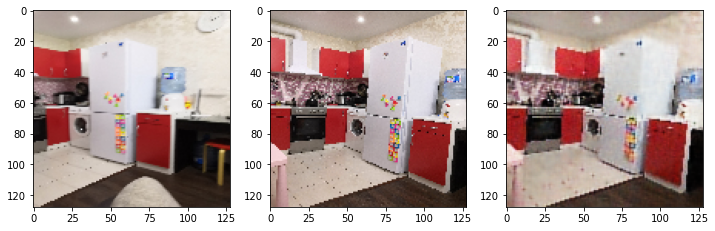

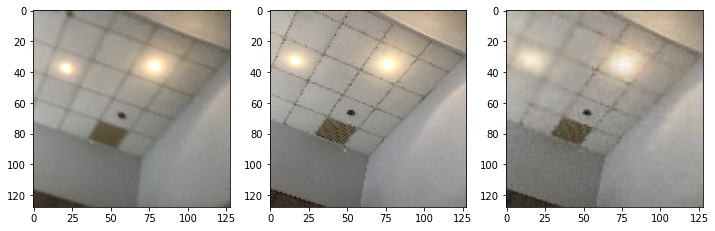

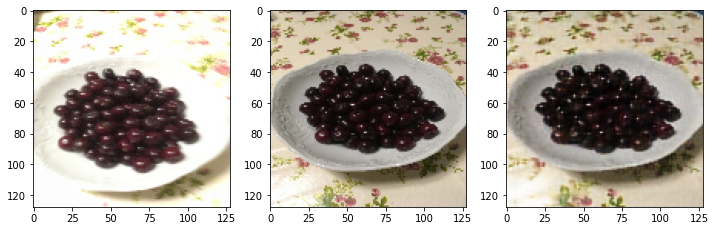

In [15]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(output_images)-1)

    x, y = input_images[r],output_images[r]
    x_inp = x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)